In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import random

torch.manual_seed(0)
random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [64]:
df = pd.read_csv("/content/winequality-white.csv", sep=';')
df = df[(df['quality'] != 3) & (df['quality'] != 9)]
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [65]:
X = df.drop('quality', axis=1).values

scaler = StandardScaler()
X = scaler.fit_transform(X)

y_original = df['quality'].values
encoder = LabelEncoder()
y = encoder.fit_transform(y_original)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [66]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.long)

In [67]:
train_data = TensorDataset(X_train, y_train)
test_data  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

In [68]:
print('num_input_feat: ', X.shape[1])
print('target_names', df['quality'].value_counts())

num_input_feat:  11
target_names quality
6    2198
5    1457
7     880
8     175
4     163
Name: count, dtype: int64


In [69]:
class Wine(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(11, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        logits = self.net(x)
        return logits


In [70]:
model = Wine().to(device)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())

net.0.weight 704
net.0.bias 64
net.2.weight 2048
net.2.bias 32
net.4.weight 160
net.4.bias 5


In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [72]:
n_epochs = 20
train_loss_history = []
val_loss_history = []
for epoch in range(n_epochs):

    # --- train ---
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # --- validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=1.2668 | val_loss=1.1729
[02] train_loss=1.0927 | val_loss=1.1100
[03] train_loss=1.0480 | val_loss=1.0885
[04] train_loss=1.0270 | val_loss=1.0826
[05] train_loss=1.0127 | val_loss=1.0699
[06] train_loss=0.9980 | val_loss=1.0717
[07] train_loss=0.9915 | val_loss=1.0540
[08] train_loss=0.9814 | val_loss=1.0516
[09] train_loss=0.9752 | val_loss=1.0442
[10] train_loss=0.9654 | val_loss=1.0476
[11] train_loss=0.9615 | val_loss=1.0461
[12] train_loss=0.9567 | val_loss=1.0387
[13] train_loss=0.9503 | val_loss=1.0371
[14] train_loss=0.9443 | val_loss=1.0323
[15] train_loss=0.9405 | val_loss=1.0360
[16] train_loss=0.9353 | val_loss=1.0297
[17] train_loss=0.9310 | val_loss=1.0390
[18] train_loss=0.9261 | val_loss=1.0311
[19] train_loss=0.9232 | val_loss=1.0324
[20] train_loss=0.9214 | val_loss=1.0371


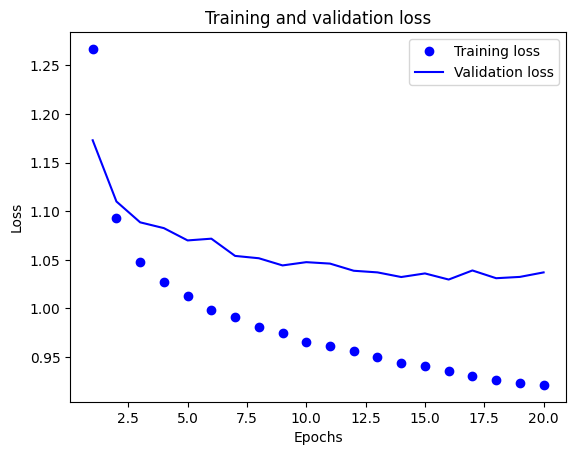

In [73]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, "bo", label="Training loss")
plt.plot(epochs, val_loss_history, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [74]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {correct/total*100:.2f}%")

Final Test Accuracy: 55.79%


kNN = 63.69%, Decision Tree = 55.38%, SVM = 66.76%, Random Forest = 64.51%, AdaBoost = 50.97%

# CNN from scratch

In [75]:
from torchvision import datasets, transforms, utils
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [76]:
tf_basic = transforms.ToTensor()

train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=tf_basic)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=tf_basic)

classes = train_set.classes
print("Класи FashionMNIST:", classes)

x0, y0 = train_set[0]
print("Приклад тензора:", x0.shape, "dtype:", x0.dtype)
print("К-сть train/val:", len(train_set), len(test_set))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 4.76MB/s]

Класи FashionMNIST: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Приклад тензора: torch.Size([1, 28, 28]) dtype: torch.float32
К-сть train/val: 60000 10000


In [77]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader   = DataLoader(test_set, batch_size=128)

Мітки: ['Trouser', 'Shirt', 'Pullover', 'Pullover', 'T-shirt/top', 'Sneaker', 'T-shirt/top', 'Shirt', 'Dress', 'Pullover']


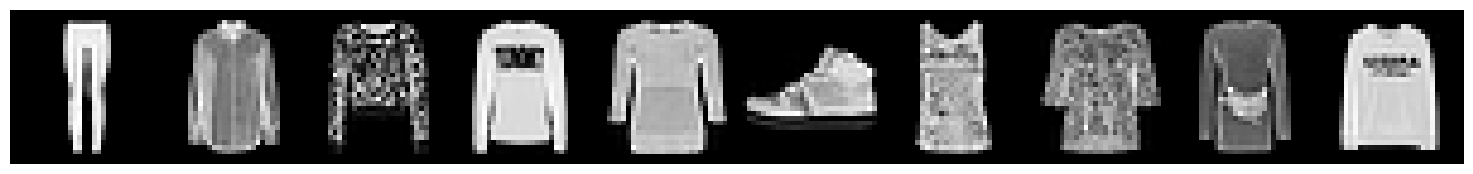

In [78]:
def show_batch(dataset, n=10):
    idx = torch.randperm(len(dataset))[:n]
    imgs = [dataset[i][0] for i in idx]
    labels = [dataset[i][1] for i in idx]
    grid = utils.make_grid(imgs, nrow=n, padding=2)
    plt.figure(figsize=(2*n, 2))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    print("Мітки:", [classes[l] for l in labels])
    plt.show()

show_batch(train_set, n=10)

In [79]:
class FashionMNIST_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2,2)

        self.drop  = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128*8*8, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.drop(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.drop(x)
        logits = self.fc2(x)
        return logits

model_basic = FashionMNIST_CNN().to(device)
print(model_basic)

FashionMNIST_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [80]:
class FashionMNIST_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.drop  = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128*7*7, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.drop(x)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.drop(x)
        logits = self.fc2(x)
        return logits

model_basic = FashionMNIST_CNN().to(device)
print(model_basic)

FashionMNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [81]:
num_params = sum(p.numel() for p in model_basic.parameters() if p.requires_grad)
print("Trainable params:", num_params)

Trainable params: 1702090


In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

In [83]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(loader)

    return train_loss

In [84]:
def evaluate_one_epoch(model, loader, criterion, device):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
      for x, y in loader:
          x, y = x.to(device), y.to(device)
          out = model(x)
          loss = criterion(out, y)

          valid_loss += loss.item()

    valid_loss /= len(loader)

    return valid_loss

In [85]:
n_epochs = 5

for epoch in range(n_epochs):
   train_loss = train_one_epoch(model_basic, train_loader, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(model_basic, test_loader, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=0.3371 | val_loss=0.2643
[02] train_loss=0.2214 | val_loss=0.2121
[03] train_loss=0.1843 | val_loss=0.1977
[04] train_loss=0.1571 | val_loss=0.1926
[05] train_loss=0.1390 | val_loss=0.1847


In [86]:
torch.save(model_basic.state_dict(), "model_from_scratch.pth")

In [87]:
@torch.no_grad()
def evaluate_accuracy(model, loader, device):
    """
    Використовується для фінальної оцінки на тестових даних.
    """
    model.eval()
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)

    acc = total_correct / total_samples
    return acc

In [88]:
test_acc = evaluate_accuracy(model_basic, test_loader, device)
print(f"Accuracy (CNN from scratch): {test_acc:.4f}")

Accuracy (CNN from scratch): 0.9328


# ResNet-18

In [89]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

transfer_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

train_set_tl = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transfer_transforms)
test_set_tl = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transfer_transforms)

train_loader_tl = DataLoader(train_set_tl, batch_size=128, shuffle=True)
test_loader_tl = DataLoader(test_set_tl, batch_size=128, shuffle=False)

In [90]:
from torchvision import models

model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features

model_resnet.fc = nn.Linear(num_ftrs, 10)
total = sum(p.numel() for p in model_resnet.parameters())
trainable = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
print(f"total: {total:,} | trainable: {trainable:,}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


total: 11,181,642 | trainable: 5,130


In [91]:
model_resnet = model_resnet.to(device)

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-3)

In [93]:
n_epochs = 5
for epoch in range(n_epochs):
   train_loss = train_one_epoch(model_resnet, train_loader_tl, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(model_resnet, test_loader_tl, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=0.6517 | val_loss=0.4722
[02] train_loss=0.4428 | val_loss=0.4287
[03] train_loss=0.4082 | val_loss=0.4148
[04] train_loss=0.3920 | val_loss=0.3969
[05] train_loss=0.3794 | val_loss=0.3879


In [94]:
torch.save(model_resnet.state_dict(), "model_resnet.pth")   #save model

In [95]:
test_acc = evaluate_accuracy(model_resnet, test_loader_tl, device)
print(f"Accuracy (ResNet-18): {test_acc:.4f}")

Accuracy (ResNet-18): 0.8632


# BiLSTM

In [96]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
import re, string
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [97]:
reviews_df = pd.read_csv('reviews_filtered.csv')
reviews_df

,rating,review_text,review_summary
0,10,An adorable romper! Belt and zipper were a lit...,So many compliments!
1,10,I rented this dress for a photo shoot. The the...,I felt so glamourous!!!
2,10,This hugged in all the right places! It was a ...,It was a great time to celebrate the (almost) ...
3,8,I rented this for my company's black tie award...,Dress arrived on time and in perfect condition.
4,10,I have always been petite in my upper body and...,Was in love with this dress !!!
...,...,...,...
9995,10,The fit was perfect. I am glad that I got the ...,I plan events for a non profit and this dress ...
9996,8,Ordered this in 10R and 12R (usually wear a 10...,Beautiful dress!
9997,2,This dress looked beautiful in pictures and on...,A disappointment!
9998,8,"I ordered a size up from my normal size, which...",Beautiful!!!


In [98]:
Counter(reviews_df['rating'])

Counter({10: 6458, 8: 2787, 4: 168, 6: 541, 2: 46})

In [99]:
reviews_df['target'] = reviews_df['rating'].apply(lambda x: 1 if x >= 8 else 0)

In [100]:
def clean_text(text):
    if not isinstance(text, str):
      return ""
    text = text.lower()
    text = re.sub(r"@\S+", " ", text)
    text = re.sub(r"https*\S+", " ", text)
    text = re.sub(r"#\S+", " ", text)
    text = re.sub(r"\d", " ", text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}',' ', text)
    return text

In [101]:
reviews_df['clean_text'] = reviews_df['review_text'].apply(clean_text)
reviews_df

,rating,review_text,review_summary,target,clean_text
0,10,An adorable romper! Belt and zipper were a lit...,So many compliments!,1,an adorable romper belt and zipper were a litt...
1,10,I rented this dress for a photo shoot. The the...,I felt so glamourous!!!,1,i rented this dress for a photo shoot the them...
2,10,This hugged in all the right places! It was a ...,It was a great time to celebrate the (almost) ...,1,this hugged in all the right places it was a p...
3,8,I rented this for my company's black tie award...,Dress arrived on time and in perfect condition.,1,i rented this for my company s black tie award...
4,10,I have always been petite in my upper body and...,Was in love with this dress !!!,1,i have always been petite in my upper body and...
...,...,...,...,...,...
9995,10,The fit was perfect. I am glad that I got the ...,I plan events for a non profit and this dress ...,1,the fit was perfect i am glad that i got the i...
9996,8,Ordered this in 10R and 12R (usually wear a 10...,Beautiful dress!,1,ordered this in r and r usually wear a r but w...
9997,2,This dress looked beautiful in pictures and on...,A disappointment!,0,this dress looked beautiful in pictures and on...
9998,8,"I ordered a size up from my normal size, which...",Beautiful!!!,1,i ordered a size up from my normal size which ...


In [102]:
X = reviews_df["clean_text"].astype(str)
y = reviews_df["target"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [103]:
tokens = [word_tokenize(t) for t in X_train]

In [104]:
counter = Counter()
for tok_list in tokens:
    counter.update(tok_list)

vocab_size = len(counter)

print(f"Кількість унікальних слів у train-наборі: {vocab_size:,}")

Кількість унікальних слів у train-наборі: 7,564


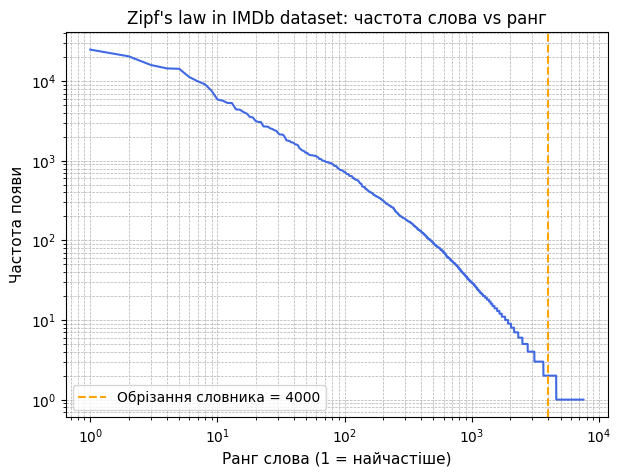

In [105]:
word_freqs = np.array(sorted(counter.values(), reverse=True))
ranks = np.arange(1, len(word_freqs) + 1)

plt.figure(figsize=(7, 5))
plt.loglog(ranks, word_freqs, color='royalblue')
plt.title("Zipf's law in IMDb dataset: частота слова vs ранг", fontsize=12)
plt.xlabel("Ранг слова (1 = найчастіше)", fontsize=11)
plt.ylabel("Частота появи", fontsize=11)
plt.grid(True, which="both", ls="--", lw=0.5)

MAX_VOCAB = 4000
plt.axvline(MAX_VOCAB, color='orange', linestyle='--', label=f'Обрізання словника = {MAX_VOCAB}')
plt.legend()

plt.show()


In [106]:
specials = ["[PAD]", "[UNK]"]
most_common = counter.most_common(MAX_VOCAB - len(specials))
itos = specials + [w for w, _ in most_common]
stoi = {w: i for i, w in enumerate(itos)}

PAD_IDX = stoi["[PAD]"]
UNK_IDX = stoi["[UNK]"]

print("Розмір словника:", len(stoi))
print("Приклад індексу:", stoi.get("dress", UNK_IDX))


Розмір словника: 4000
Приклад індексу: 8


In [107]:
def encode(tokens):
    return [stoi.get(t, UNK_IDX) for t in tokens]

encoded_texts = [encode(tok_list) for tok_list in tokens]
print(encoded_texts[0][:20])

[315, 313, 9, 239, 13, 10, 1029, 5, 20, 32, 1135, 144, 70, 11, 2, 131, 7, 71, 17, 3]


In [108]:
MAX_LEN = 100
def pad_sequence(seq):
    seq = seq[:MAX_LEN] + [PAD_IDX] * max(0, MAX_LEN - len(seq))
    return torch.tensor(seq, dtype=torch.long)

X = torch.stack([pad_sequence(seq) for seq in encoded_texts])
print(X.shape)

torch.Size([7500, 100])


In [109]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32)

print(y_train_tensor.shape)

torch.Size([7500])


In [110]:
full_train_dataset = TensorDataset(X, y_train_tensor)


VAL_FRAC = 0.2
val_sz = int(len(full_train_dataset) * VAL_FRAC)
train_sz = len(full_train_dataset) - val_sz

train_ds, val_ds = random_split(
    full_train_dataset,
    [train_sz, val_sz],
    generator=torch.Generator().manual_seed(0)
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

In [111]:
tokens_test = [word_tokenize(t) for t in X_test]

def encode(tokens):
    return [stoi.get(t, UNK_IDX) for t in tokens]

encoded_test = [encode(toks) for toks in tokens_test]

def pad_sequence(seq):
    seq = seq[:MAX_LEN] + [PAD_IDX] * max(0, MAX_LEN - len(seq))
    return torch.tensor(seq, dtype=torch.long)

X_test_tensor = torch.stack([pad_sequence(seq) for seq in encoded_test])

y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)

test_ds = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

print("Test Loader готовий!")
print(f"Розмір X_test: {X_test_tensor.shape}")
print(f"Розмір y_test: {y_test_tensor.shape}")

Test Loader готовий!
Розмір X_test: torch.Size([2500, 100])
Розмір y_test: torch.Size([2500])


In [112]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(loader)

    return train_loss

In [113]:
def evaluate_one_epoch(model, loader, criterion, device):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
      for x, y in loader:
          x, y = x.to(device), y.to(device)
          out = model(x)
          loss = criterion(out, y)
          valid_loss += loss.item()
    valid_loss /= len(loader)

    return valid_loss

In [114]:
class Review(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, pad_idx,
                 num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x = self.embedding(x)

        out, (h, c) = self.lstm(x)
        h_fwd = h[-2, :, :]
        h_bwd = h[-1, :, :]
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)

        logits = self.fc(h_cat)
        return logits.squeeze(1)

In [115]:
vocab_size = len(stoi)
emb_dim = 100
hidden_dim = 64
pad_idx = stoi["[PAD]"]

model_basic = Review(vocab_size, emb_dim, hidden_dim, pad_idx).to(device)
print(model_basic)

Review(
  (embedding): Embedding(4000, 100, padding_idx=0)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [116]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

In [117]:
n_epochs = 5

for epoch in range(n_epochs):
   train_loss = train_one_epoch(model_basic, train_loader, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(model_basic, val_loader, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=0.3253 | val_loss=0.2400
[02] train_loss=0.2480 | val_loss=0.2227
[03] train_loss=0.2134 | val_loss=0.2096
[04] train_loss=0.1967 | val_loss=0.2142
[05] train_loss=0.1726 | val_loss=0.2100


In [118]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, n = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        preds = (torch.sigmoid(logits) >= 0.5).long()
        total_loss += loss.item() * xb.size(0)
        total_acc  += (preds == yb.long()).sum().item()
        n += xb.size(0)
    return total_loss/n, total_acc/n

In [119]:
test_loss, test_acc = evaluate(model_basic, test_loader, criterion, device)
print(f"TEST  loss={test_loss:.4f}  acc={test_acc*100:.2f}%")


TEST  loss=0.2210  acc=92.04%


# GloVe

In [120]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [121]:
def load_glove_txt(path):
    vectors = {}
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            vectors[word] = vec
    dim = len(next(iter(vectors.values())))
    return vectors, dim

glove_path = "glove.6B.100d.txt"
glove, emb_dim = load_glove_txt(glove_path)
print("GloVe dim:", emb_dim, "| entries:", len(glove))

GloVe dim: 100 | entries: 400000


In [122]:
vocab_size = len(stoi)
PAD_IDX = stoi["[PAD]"]
UNK_IDX = stoi["[UNK]"]

emb_matrix = np.random.normal(scale=0.1, size=(vocab_size, emb_dim)).astype(np.float32)
emb_matrix[PAD_IDX] = 0.0

hit = 0
for w, idx in stoi.items():
    v = glove.get(w)
    if v is not None:
        emb_matrix[idx] = v
        hit += 1
print(f"Coverage: {hit}/{vocab_size} = {hit/vocab_size:.1%}")

Coverage: 3955/4000 = 98.9%


In [123]:
pretrained_emb = nn.Embedding.from_pretrained(
    torch.tensor(emb_matrix),
    freeze=True,
    padding_idx=PAD_IDX
).to(device)
emb_dim= 100
model_tl = Review(vocab_size, emb_dim, hidden_dim, pad_idx).to(device)
model_tl.embedding = pretrained_emb

In [124]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-3)

In [125]:
n_epochs = 10

for epoch in range(n_epochs):
   train_loss = train_one_epoch(model_tl, train_loader, optimizer, criterion, device)
   val_loss = evaluate_one_epoch(model_tl, val_loader, criterion, device)

   print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[01] train_loss=0.3036 | val_loss=0.2446
[02] train_loss=0.2703 | val_loss=0.2417
[03] train_loss=0.2663 | val_loss=0.2375
[04] train_loss=0.2645 | val_loss=0.2363
[05] train_loss=0.2579 | val_loss=0.2358
[06] train_loss=0.2547 | val_loss=0.2319
[07] train_loss=0.2411 | val_loss=0.2350
[08] train_loss=0.2264 | val_loss=0.2196
[09] train_loss=0.2154 | val_loss=0.2202
[10] train_loss=0.2029 | val_loss=0.2211


In [126]:
test_loss, test_acc = evaluate(model_tl, test_loader, criterion, device)
print(f"TEST  loss={test_loss:.4f}  acc={test_acc*100:.2f}%")

TEST  loss=0.2306  acc=92.20%
